In [15]:
import os
os.getcwd()

'c:\\Users\\cmuro\\OneDrive\\Documentos\\Machine_Learning_Projects_and_Notes'

# Fraud Detection with Python - Notes

Examples of fraud detection are insurance fraud, credit card fraud, money laundering, tax evasion, etc.

Fraud is:
* uncommon
* concealed
* changing over time
* organized   

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_1 = pd.read_csv("datasets/fraud_detection_datacamp/chapter_2/creditcard_sampledata_2.csv")
print(df_1.info())

df = df_1.drop('Unnamed: 0', axis=1)

print(df.info())

occ = df["Class"].value_counts()


print(occ)

print('The ratio is', occ/df.count()[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7300 non-null   int64  
 1   V1          7300 non-null   float64
 2   V2          7300 non-null   float64
 3   V3          7300 non-null   float64
 4   V4          7300 non-null   float64
 5   V5          7300 non-null   float64
 6   V6          7300 non-null   float64
 7   V7          7300 non-null   float64
 8   V8          7300 non-null   float64
 9   V9          7300 non-null   float64
 10  V10         7300 non-null   float64
 11  V11         7300 non-null   float64
 12  V12         7300 non-null   float64
 13  V13         7300 non-null   float64
 14  V14         7300 non-null   float64
 15  V15         7300 non-null   float64
 16  V16         7300 non-null   float64
 17  V17         7300 non-null   float64
 18  V18         7300 non-null   float64
 19  V19         7300 non-null  

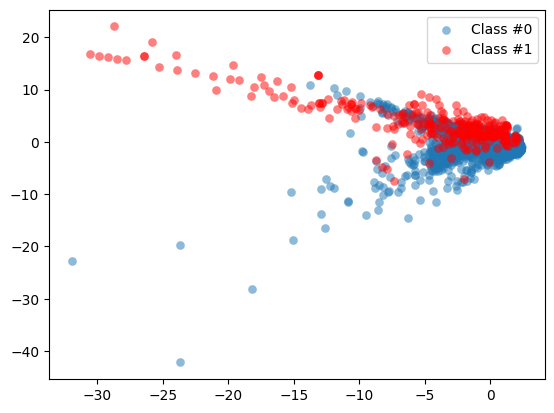

In [13]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X, y):
	plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
	plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
	plt.legend()
	return plt.show()

def prep_data(df):
    X = df.iloc[:, 1:29]
    X = np.array(X).astype(np.float)
    y = df.iloc[:, 29]
    y=np.array(y).astype(np.float)
    return X,y

# Create X and y from the prep_data function
X = df.loc[:, ~df.columns.isin(["Class"])].values
y = df['Class'].values

# Plot our data by running our plot data function on X and y
plot_data(X,y)

## Increasing successful detections using data resampling


In [ ]:
#### Oversampling in Python
from imblearn.over_sampling import RandomOverSampler
method = RandomOverSampler()


The synthetic minority oversampling technique (SMOTE) is another way of adjusting by oversampling the minority observations, or fraud cases.  

When it comes to oversampling, SMOTE is more sophisticated as it does not duplicate data, but it only works well if the fraud cases are quite similar to each other.
  
Only resampling on the training set.  

In [14]:
from imblearn.over_sampling import SMOTE 

X, y = prep_data(df)

# Define the resampling method
method = SMOTE()

# Create the resampled feature set
X_resampled, y_resampled = method.fit_resample(X,y)

C:\Users\cmuro\AppData\Local\Temp\ipykernel_29892\2447378725.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.array(X).astype(np.float)
C:\Users\cmuro\AppData\Local\Temp\ipykernel_29892\2447378725.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=np.array(y).astype(np.float)


### Fraud detection using labeled data

Let's now create a first random forest classifier for fraud detection

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

model = RandomForestClassifier(random_state=5)

model.fit(X_train,y_train)

predicted = model.predict(X_test)

In [21]:
# Print the accuracy performance metric
print(accuracy_score(y_test, predicted))

0.9922374429223745


Accuracy is not a reliable performance metric for unbalanced data.  
For false positive we call them Type 1 error.  
For false negative we call them Type 2 error.  

For instance, a credit card company wants to catch much fraud as possible and reduce false negative.  
On the other hand, an insurance company can not handle many false alarms.  

A metric more suitable for the credit card company is the Recall, which is defined as:  
$$ Recall = \frac{ True\quad positives}{True\quad positives\quad +\quad False\quad negatives}, $$ 
  
And the insurance company is more intereseted on the precision:  
$$ Precision = \frac{True\quad positives}{True\quad positives\quad +\quad False\quad positives}. $$  
  
The F1 score is a measure that takes into account a balance between precision and recall  
$$F1-score = 2*\frac{Precision*Recall}{Precision + Recall}$$  
  
Another useful measure is the area under the ROC curve or AUC. AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. The ROC curve is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.
In scitkit-learn we call the method as:  
from sklearn.metrics import roc_auc_score

In [26]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, average_precision_score, precision_recall_curve
#Predicted probabilites
probs = model.predict_proba(X_test)

print("The AUROC is : ",roc_auc_score(y_test,probs[:,1]))
print("The classification report is \n",classification_report(y_test,predicted))
print("The confusion matrix is: \n",confusion_matrix(y_test, predicted))

The AUROC is :  0.9815584605960975
The classification report is 
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2099
         1.0       0.96      0.85      0.90        91

    accuracy                           0.99      2190
   macro avg       0.98      0.92      0.95      2190
weighted avg       0.99      0.99      0.99      2190

The confusion matrix is: 
 [[2096    3]
 [  14   77]]


In [27]:
# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)

# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, predicted)



In scikit-learn there are two options to tweak the model for heavily imbalanced data.
rf = RandomForestClassifier(class_weight="balanced")  
rf = RandomForestClassifier(class_weight ="balanced_subsample")  

The balanced option is also avalaible in other classifiers.
It can alsot takes a manual input(class_weight={0:1,1:4}, random_state = 42)   
  
#### Hyperparameter tuning  
Using GridSearch  
from sklearn.model_selection import GridSearchCV  
  
param_grid = {
    'max_depth' = [80,90,100,110],
    'max_features' = [2,3],
    'min_samples_leaf' = [3,4,5],
    'min_samples_split' = [8,10,12],
    'n_estimators' = [100,200,300,1000]
}  

model = RandomForestRegressor()
  
grid_search_model = GridSearchCV(estimator=model, param_grid = param_grid, cv = 5, n_jobs =-1, scoring = 'f1')  

grid_search_model.fit(X_train, y_train)  

best_model = grid_seach_model.best_estimator_
  
best_model.best_params_  
best_model.best_score_  


In [29]:
model = RandomForestClassifier(class_weight='balanced_subsample',random_state=66)
model.fit(X_train,y_train)

predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

print("The AUROC is : ",roc_auc_score(y_test,probs[:,1]))

The AUROC is :  0.9762576632514699


In [39]:
def get_model_results(X_train, y_train, X_test, y_test, model):
  model.fit(X_train, y_train)
  predicted = model.predict(X_test)
  probs = model.predict_proba(X_test)
  print (classification_report(y_test, predicted))
  print (confusion_matrix(y_test, predicted))
  print("The area under roc curve is: ",roc_auc_score(y_test,probs[:,1]))
  print("The average precision score is: ", average_precision_score(y_test,probs[:,1]))
  

In [33]:
# Change the model options
model = RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:12}, criterion='entropy',
			
			# Change depth of model
            max_depth=10,
		
			# Change the number of samples in leaf nodes
            min_samples_leaf=10, 

			# Change the number of trees to use
            n_estimators=20, n_jobs=-1, random_state=5)

# Run the function get_model_results
get_model_results(X_train, y_train, X_test, y_test, model)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2099
         1.0       0.93      0.88      0.90        91

    accuracy                           0.99      2190
   macro avg       0.96      0.94      0.95      2190
weighted avg       0.99      0.99      0.99      2190

[[2093    6]
 [  11   80]]
0.9774146767953342


In [34]:
from sklearn.model_selection import GridSearchCV

# Define the parameter sets to test
param_grid = {'n_estimators': [1, 30], 'max_features': ['auto', 'log2'],  'max_depth': [4, 8], 'criterion': ['gini', 'entropy']
}

# Define the model to use
model = RandomForestClassifier(random_state=5)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

c:\Users\cmuro\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 30}

In [35]:
CV_model.best_score_

0.8133565621370499

In [40]:
# Get results from the best model
get_model_results(X_train, y_train, X_test, y_test, CV_model.best_estimator_)

c:\Users\cmuro\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2099
         1.0       0.96      0.85      0.90        91

    accuracy                           0.99      2190
   macro avg       0.98      0.92      0.95      2190
weighted avg       0.99      0.99      0.99      2190

[[2096    3]
 [  14   77]]
The area under roc curve is:  0.9739567245522462
The average precision score is:  0.9137737566202446


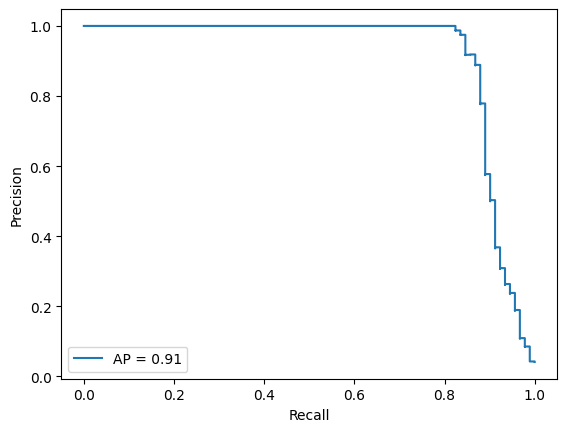

In [41]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
precision, recall, threshold = precision_recall_curve(y_test,CV_model.best_estimator_.predict_proba(X_test)[:,1])
ap = average_precision_score(y_test,CV_model.best_estimator_.predict_proba(X_test)[:,1])
prd = PrecisionRecallDisplay(precision,recall, average_precision=ap)
prd.plot()


## Fraud detection with unlabeled data
* Using unsupervised learning to distinguish normal from abnormal behavior   
* Abnormal behavior by definition is not always fraudelent  
* Challenging because difficult to validate


What is normal behavior?  
* Thouroughly describe your data: plot histograms, check for outliers, investigate correlations and talk with a fraud analyst  
* Are there any known historic cases of fraud? What typifies those cases?
* Normal behavior of one type of client may not be normal for another   
* Check patterns within subgroups of data

In [5]:
import os
os.listdir(path = "datasets/fraud_detection_datacamp/chapter_3/")


['banksim.csv',
 'banksim_adj.csv',
 'db_full.pickle',
 'labels.pickle',
 'labels_full.pickle',
 'x_scaled.pickle',
 'x_scawed_full.pickle']

In [9]:
import pandas as pd
df_1 = pd.read_csv("datasets/fraud_detection_datacamp/chapter_3/banksim.csv")
df = df_1.drop("Unnamed: 0", axis=1)
df.head()


,age,gender,category,amount,fraud
0,3,F,es_transportation,49.71,0
1,4,F,es_health,39.29,0
2,3,F,es_transportation,18.76,0
3,4,M,es_transportation,13.95,0
4,2,M,es_transportation,49.87,0


In [11]:
print(df.groupby("category").median())

                         amount  fraud
category                              
es_barsandrestaurants   41.5100    0.0
es_contents             50.5700    0.0
es_fashion              44.0900    0.0
es_food                 29.7150    0.0
es_health              123.8400    0.0
es_home                125.0300    0.0
es_hotelservices       228.0500    1.0
es_hyper                37.8300    0.0
es_leisure             236.1474    1.0
es_otherservices       166.9050    1.0
es_sportsandtoys       176.8550    1.0
es_tech                141.1700    0.0
es_transportation       25.8600    0.0
es_travel              236.1474    1.0
es_wellnessandbeauty    54.0550    0.0


C:\Users\cmuro\AppData\Local\Temp\ipykernel_4360\3798943943.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(df.groupby("category").median())


In [13]:
# Group by age groups and get the mean
print(df.groupby('age').mean())

        amount     fraud
age                     
0    49.468935  0.050000
1    35.622829  0.026648
2    37.228665  0.028718
3    37.279338  0.023283
4    36.197985  0.035966
5    37.547521  0.023990
6    36.700852  0.022293
U    39.117000  0.000000


C:\Users\cmuro\AppData\Local\Temp\ipykernel_4360\469801209.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(df.groupby('age').mean())


Using statistics to define normal behavior  
  
In the previous exercises we saw that fraud is more prevalent in certain transaction categories, but that there is no obvious way to segment our data into for example age groups. This time, let's investigate the average amounts spend in normal transactions versus fraud transactions. This gives you an idea of how fraudulent transactions differ structurally from normal transactions.

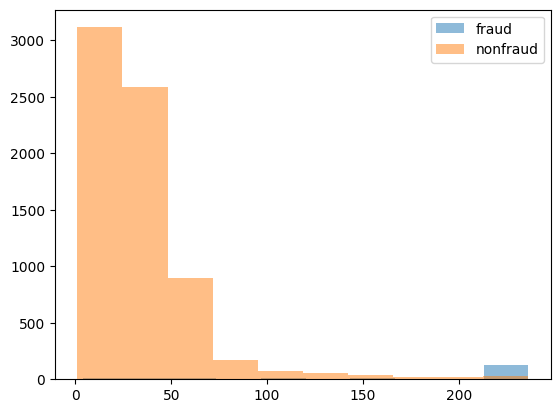

In [14]:
import matplotlib.pyplot as plt

df_fraud = df.loc[df.fraud == 1]
df_non_fraud = df.loc[df.fraud == 0]

plt.hist(df_fraud.amount, alpha = 0.5, label="fraud")
plt.hist(df_non_fraud.amount, alpha =0.5, label= "nonfraud")
plt.legend()
plt.show()

As the number fraud observations is much smaller, it is difficult to see the full distribution. Nonetheless, we can see that the fraudulent transactions tend to be on the larger side relative to normal obervations. This is good news, as it helps us later in detecting fraud from non-fraud. We're going to implement a clustering model to distinguish between normal and abnormal transactions, when the fraud labels are no longer available.

#### Clustering methods to detect fraud  
Remind that in K - means we use the distance to cluster centroids. In scikit learn:  
  
from sklearn.preprocessing import MinMaxScaler    
from sklearn.cluster import KMeans  

-- We need to transform and scale the data  
X = np.array(df).astype(np.float64)  
scaler = MinMaxScaler()  
X_scaled = scaler.fit_transform(X)  

kmeans = KMeans(n_clusters = 6, random_state = 42).fit(X_scaled)  
  
The drawback of KMeans clustering is that we need to assign the number of clusters beforehand. We can check the right amount of clusters should be by using the  
* Silhouette method    
* Elbow curve  
    
 clust = range(1,10)  
 kmeans = [KMeans(n_clusters) for i in clust]     
 score = [kmeans[i].fit(X_scaled) for i in range(len(kmeans))]   
 plt.plot(clust,score)  
 plt.xlabel("Number of clusters")  
 plt.ylabel("Elbow curve")  
 plt.show()   





In [26]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

scaler = MinMaxScaler()  

X = df.loc[:,~df.columns.isin(['Unnamed: 0', 'fraud'])]
y = df["fraud"]

num_cols = X.select_dtypes(exclude = 'object').columns.tolist()
cat_cols = X.select_dtypes(include = 'object').columns.tolist()

cat_pipe = Pipeline([("ohe", OneHotEncoder(handle_unknown="ignore",drop="first",sparse=False))])
num_pipe = Pipeline([("scaler",scaler)])

preprocess = ColumnTransformer([("num_values",num_pipe,num_cols),("cat_values",cat_pipe,cat_cols)])

transform_pipeline = Pipeline([("preprocess",preprocess)])

X_transformed = transform_pipeline.fit_transform(X)





c:\Users\cmuro\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


 MiniBatch K-means is an efficient way to implement K-means on a large dataset.  
 Let us get the right number of clusters.  

c:\Users\cmuro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\cmuro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\cmuro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\cmuro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available 

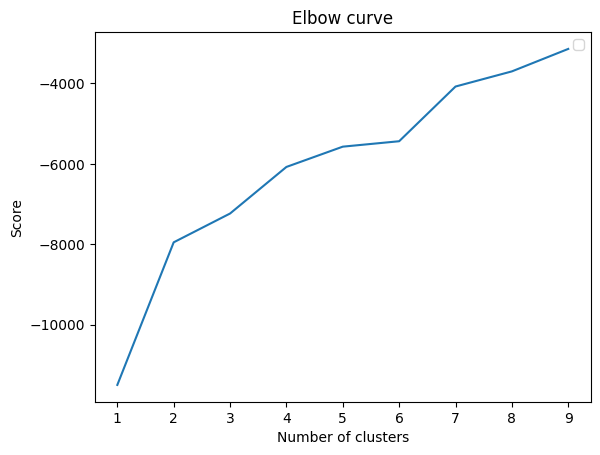

In [32]:
from sklearn.cluster import MiniBatchKMeans

clustno = range(1,10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i, random_state=0) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_transformed).score(X_transformed) for i in range(len(kmeans))]

plt.plot(clustno,score)
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.title("Elbow curve")
plt.legend()
plt.show()

We can observe that the ideal number of clusters can be 2 or 3.  

Now, how we go from clustering data to fraud detection?  
In a nutshell, we take the outliers of each cluster, and flag those as fraud.  

In a first step, you need to collect and store the cluster centroids in memory, as that is the starting point to decide what's normal and what's not.  
   
The next step is to calculate the distance of each point in the dataset to their own cluster centroid. 
   
We also need to define a cut-off point for the distances to define what is an outlier. We do these based on the distributions of the distances collected.  
   
Suppose you decide everything that has a bigger distance than the top 95th percentile should be considered an outlier, i.e. take the tail of the distribution of the distances.  

Those these points can be described as abnormal or suspicious. It does not mean that these observations are also fraudelent. 
  
**Validating the model results**  
* Check with the fraud analyst  
* Investigate and describe cases that are flagged in more detail 
* Compare to past known cases of fraud    



In [36]:
# Define the K-Means model  
kmeans = MiniBatchKMeans(n_clusters=2, 
                         random_state=66)
X_clusters = kmeans.fit_predict(X_transformed)
X_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x,y in zip(X_transformed,
                                      X_clusters_centers[X_clusters])]  

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0


c:\Users\cmuro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\cmuro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [47]:
dist_series = pd.Series(dist, name='euc_dist')
km_y_pred_series = pd.Series(km_y_pred, name='km_y_pred')


X_complete = pd.concat([X, dist_series, km_y_pred_series], axis=1)
X_complete

,age,gender,category,amount,euc_dist,km_y_pred
0,3,F,es_transportation,49.7100,0.896289,0.0
1,4,F,es_health,39.2900,1.575786,0.0
2,3,F,es_transportation,18.7600,0.898624,0.0
3,4,M,es_transportation,13.9500,0.934852,0.0
4,2,M,es_transportation,49.8700,0.796892,0.0
...,...,...,...,...,...,...
7195,5,M,es_hotelservices,236.1474,1.852067,1.0
7196,5,F,es_hotelservices,139.6000,1.687835,1.0
7197,1,F,es_travel,236.1474,1.841691,1.0
7198,1,M,es_hotelservices,236.1474,1.856644,1.0


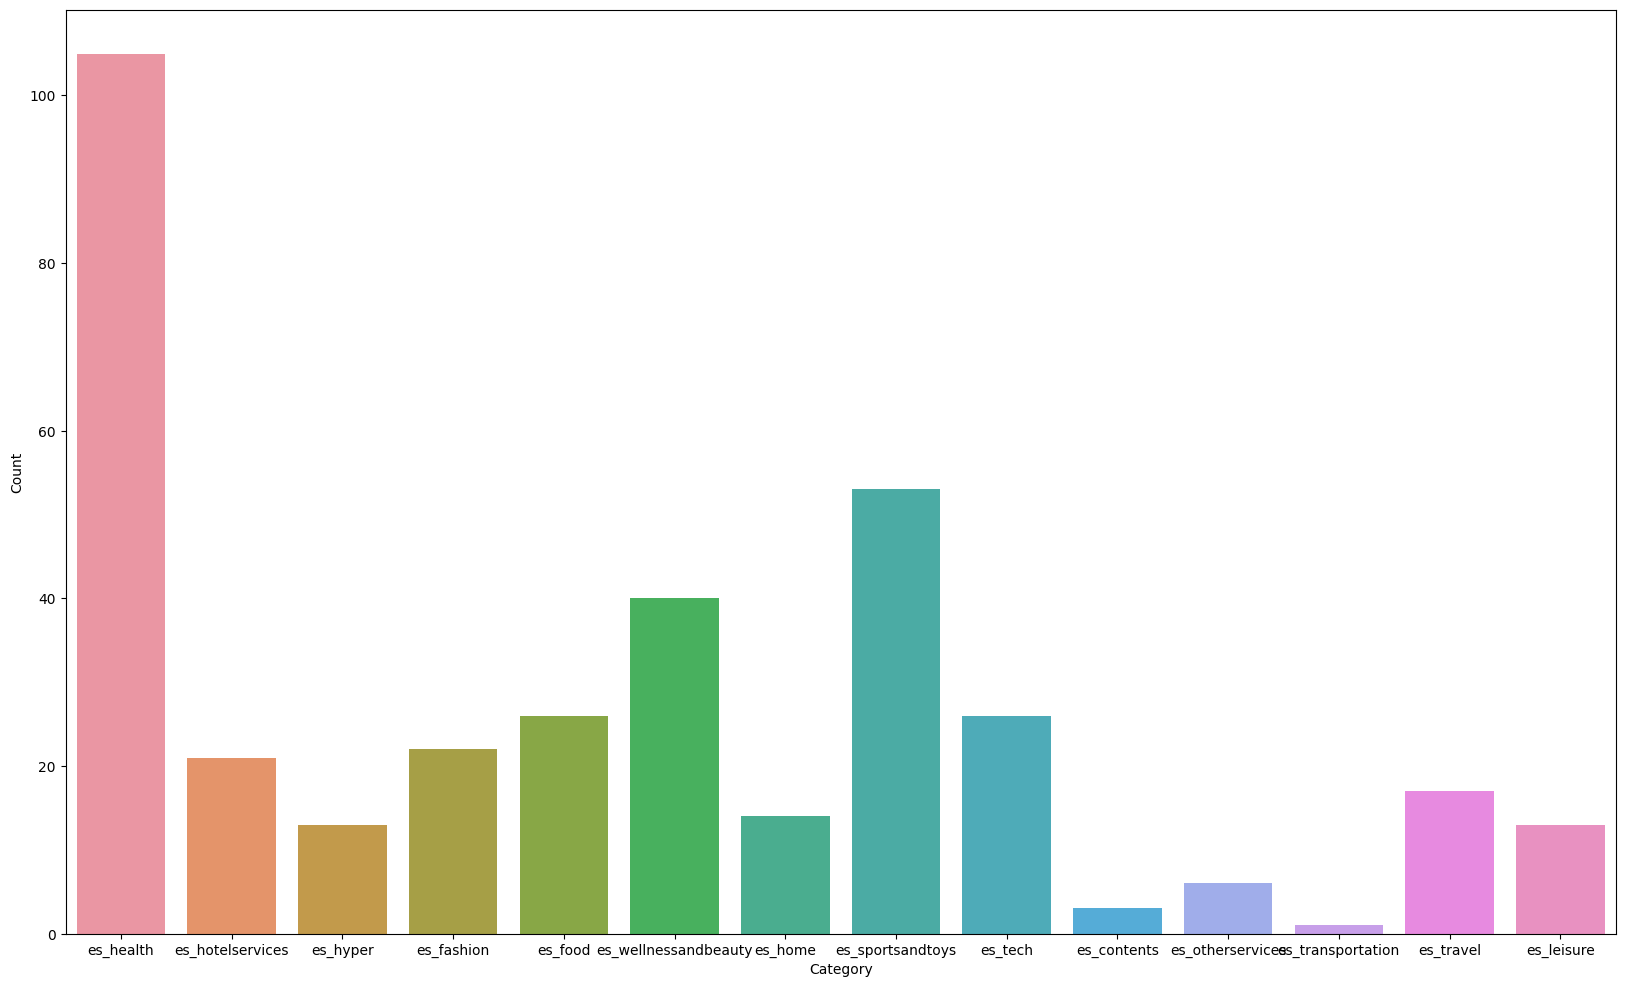

In [57]:
import seaborn as sns
X_complete_abnormal = X_complete[X_complete["km_y_pred"]== 1.0]
plt.figure(figsize=(20, 12))
sns.countplot(data=X_complete_abnormal,x="category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

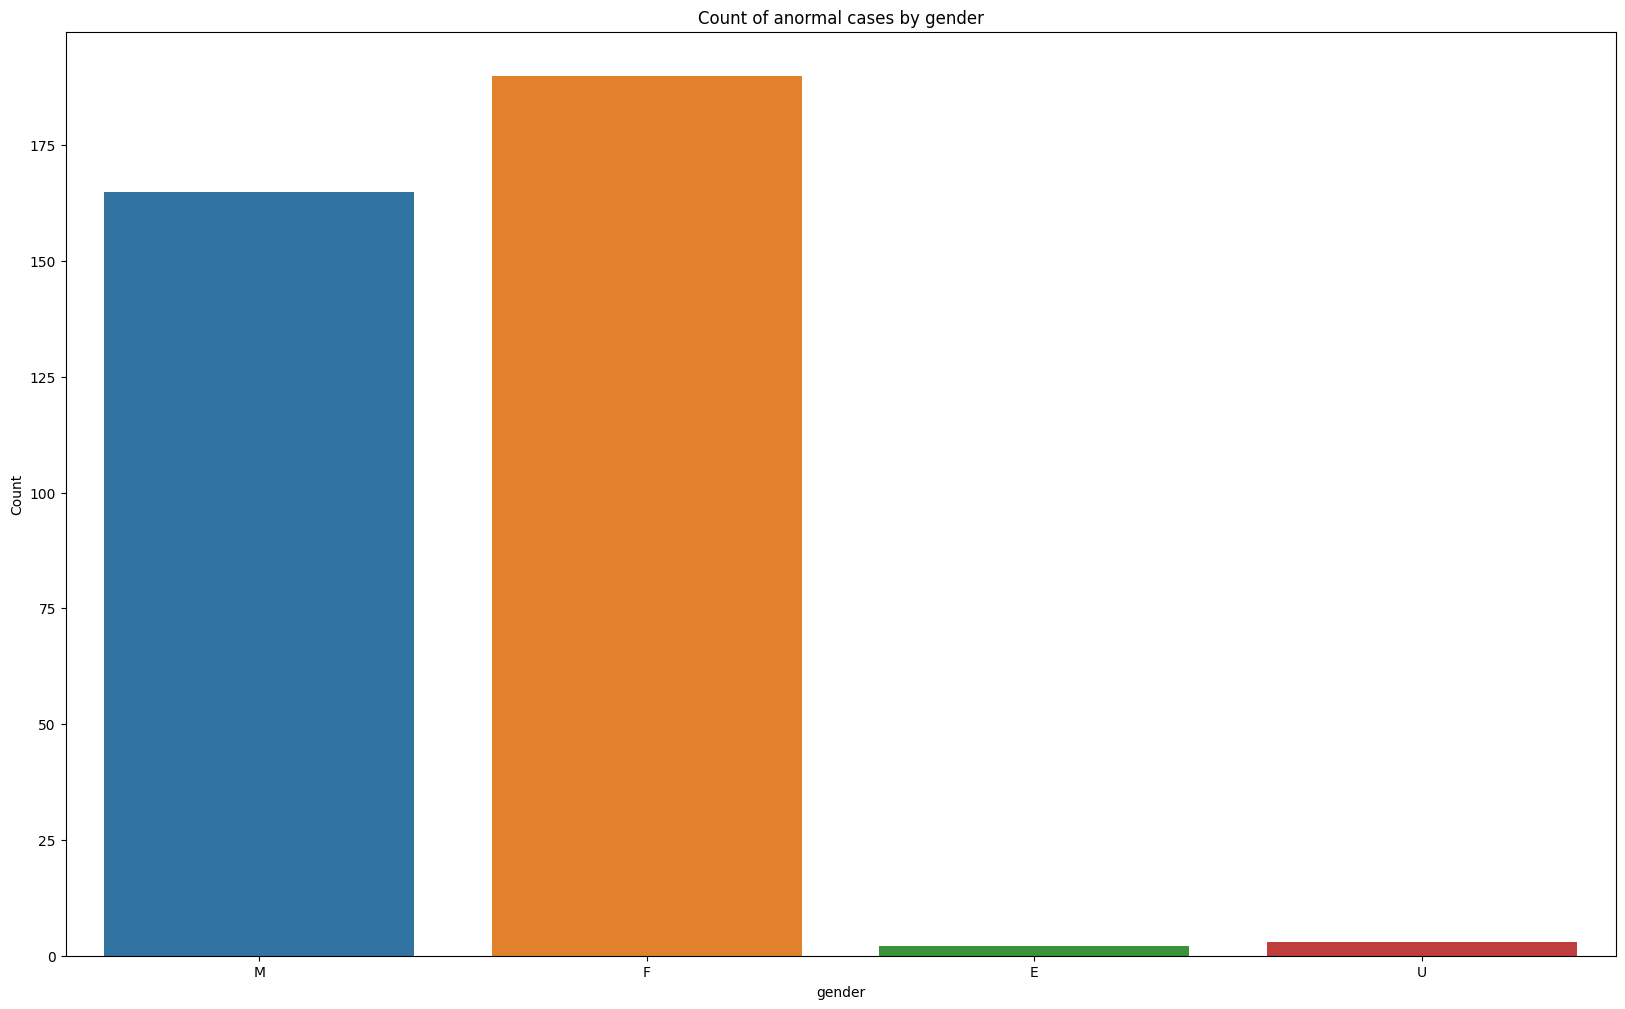

In [64]:
plt.figure(figsize=(20,12))
sns.countplot(data=X_complete_abnormal,x="gender")
plt.xlabel("gender")
plt.ylabel("Count")
plt.title("Count of anormal cases by gender")
plt.show()

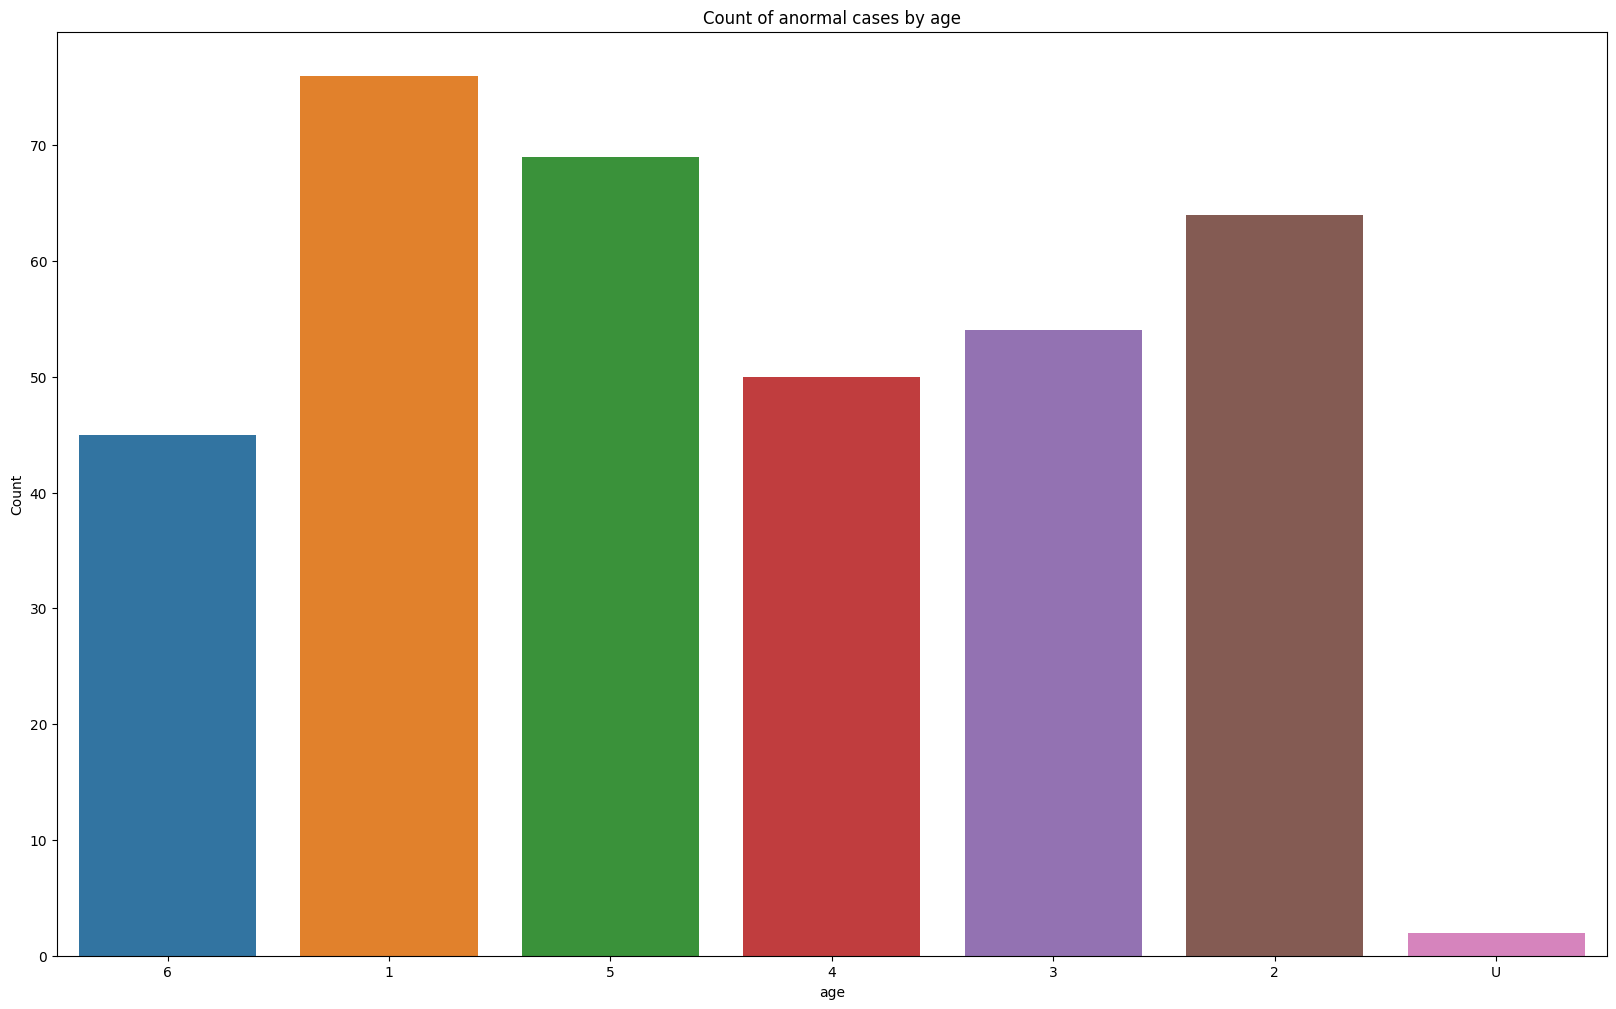

In [63]:
plt.figure(figsize=(20, 12))
sns.countplot(data=X_complete_abnormal,x="age")
plt.xlabel("age")
plt.ylabel("Count")
plt.title("Count of anormal cases by age")
plt.show()

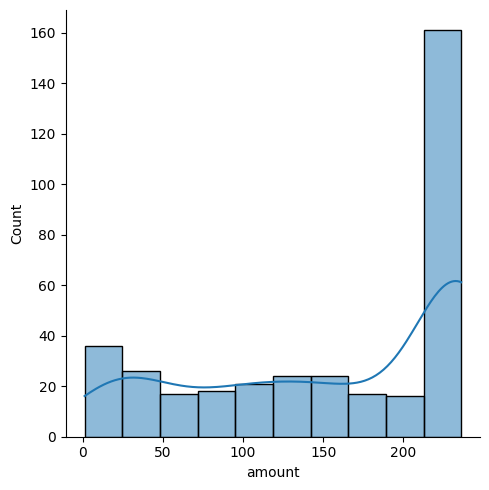

In [66]:
import seaborn as sns
sns.displot(data=X_complete_abnormal["amount"],kde= True)
plt.show()

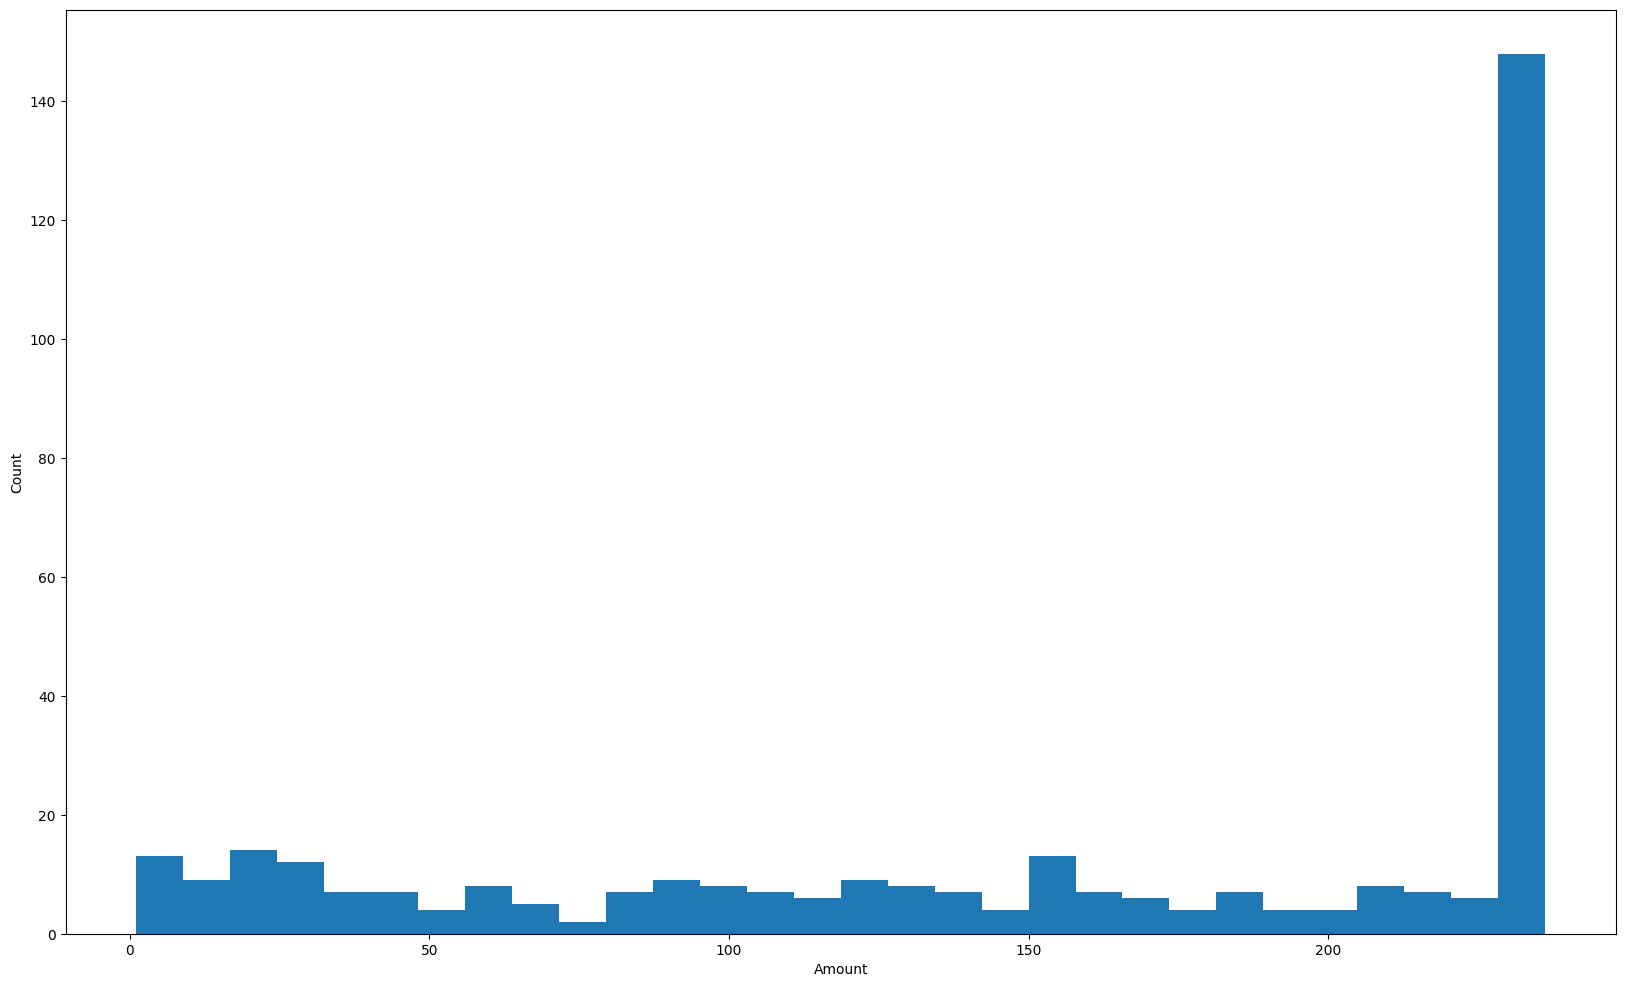

In [62]:
plt.figure(figsize=(20, 12))
plt.hist(X_complete_abnormal["amount"], bins=30)
plt.xlabel("Amount")
plt.ylabel("Count")
plt.show()

# Unsupervised Learning for Fraud Detection
## César Muro Cabral


In this project, we employ the clustering methods K-Means and DBSCAN to detect fraud.  
  
We look at bank payment transaction data. The financial transactions are categorized by type of expense, as well as the amount spent. Moreover, some client characteristics available such as age group and gender. Some of the transactions are labelled as fraud; we'll treat these labels as given and will use those to validate the results.    
  
We employ two clustering models: minibatchkmeans and dbscan.   
  
For kmeans, we construct a pipeline with two steps: a preprocessor step to transform the data and the model. We find the best hyperparameters using the library optuna.    
  
For the dbscan, we initialize the model setting the maximum distance between two samples to 0.9 and the minimum observations in the clusters to 10.   

## Exploring data analysis

The fields or columns of the dataset are:

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("banksim.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7200 non-null   int64  
 1   age         7200 non-null   object 
 2   gender      7200 non-null   object 
 3   category    7200 non-null   object 
 4   amount      7200 non-null   float64
 5   fraud       7200 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 337.6+ KB


In [ ]:
df.head(15)

,Unnamed: 0,age,gender,category,amount,fraud
0,171915,3,F,es_transportation,49.71,0
1,426989,4,F,es_health,39.29,0
2,310539,3,F,es_transportation,18.76,0
3,215216,4,M,es_transportation,13.95,0
4,569244,2,M,es_transportation,49.87,0
5,153631,4,F,es_hyper,57.82,0
6,290621,5,F,es_transportation,27.26,0
7,78537,2,F,es_transportation,7.61,0
8,56239,4,M,es_transportation,42.01,0
9,562564,2,F,es_transportation,21.08,0


Let's visualize the distribution of each field and check whether there are any obvious patterns for the clients.  
  
The different categories are:

In [ ]:
df['category'].value_counts()

es_transportation        5975
es_food                   294
es_health                 243
es_wellnessandbeauty      198
es_fashion                 97
es_barsandrestaurants      89
es_hyper                   80
es_sportsandtoys           76
es_tech                    39
es_hotelservices           31
es_home                    24
es_travel                  18
es_contents                13
es_leisure                 13
es_otherservices           10
Name: category, dtype: int64

where their distribution according if they are fraudulent is:

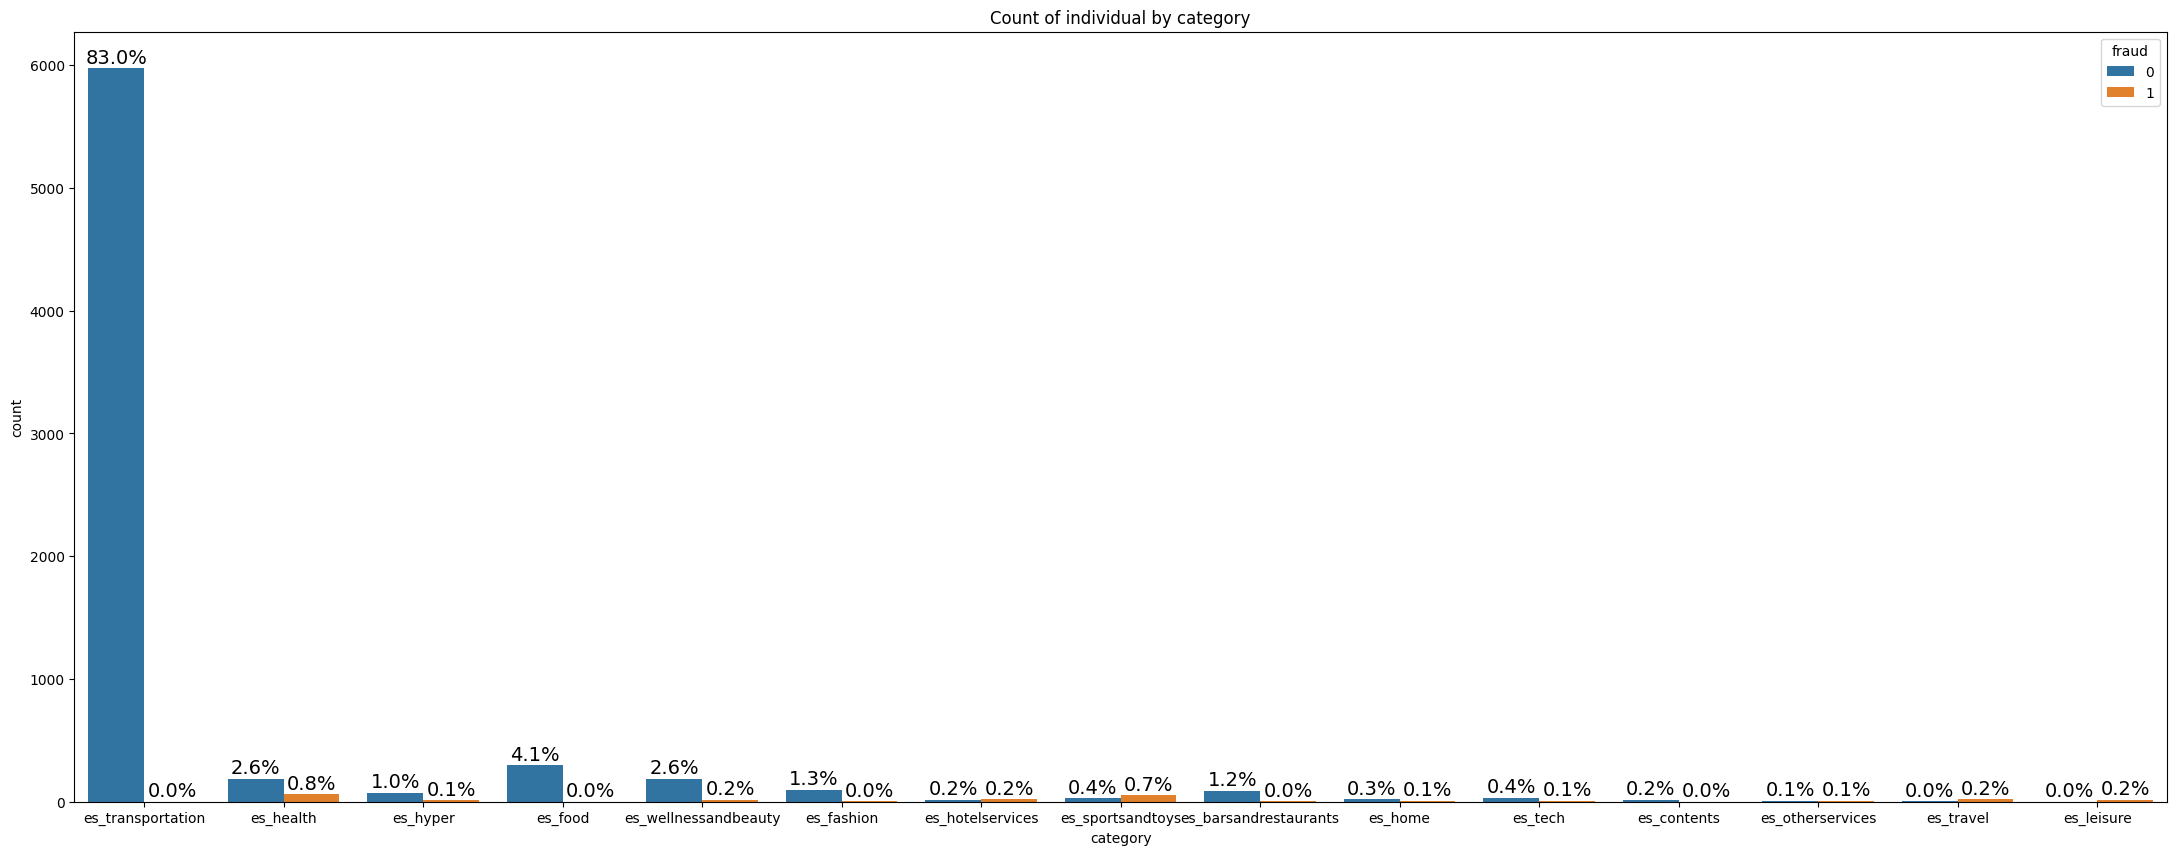

In [ ]:
total = len(df)
fig, axes = plt.subplots(1,1,figsize=(27,10))
sns.countplot(x='category', hue='fraud', data=df, ax=axes)
axes.set(title="Count of individual by category", xlabel='category')
for p in axes.patches:
    percentage=f'{100*p.get_height()/total:.1f}%\n'
    x=p.get_x()+p.get_width()/2
    y=p.get_height()
    axes.annotate(percentage,(x,y),ha='center',va='center',fontsize=14)

We observe that the category "es_sports and toys" presents more fraudelent cases.  
  
Now, let us inspect by gender:  

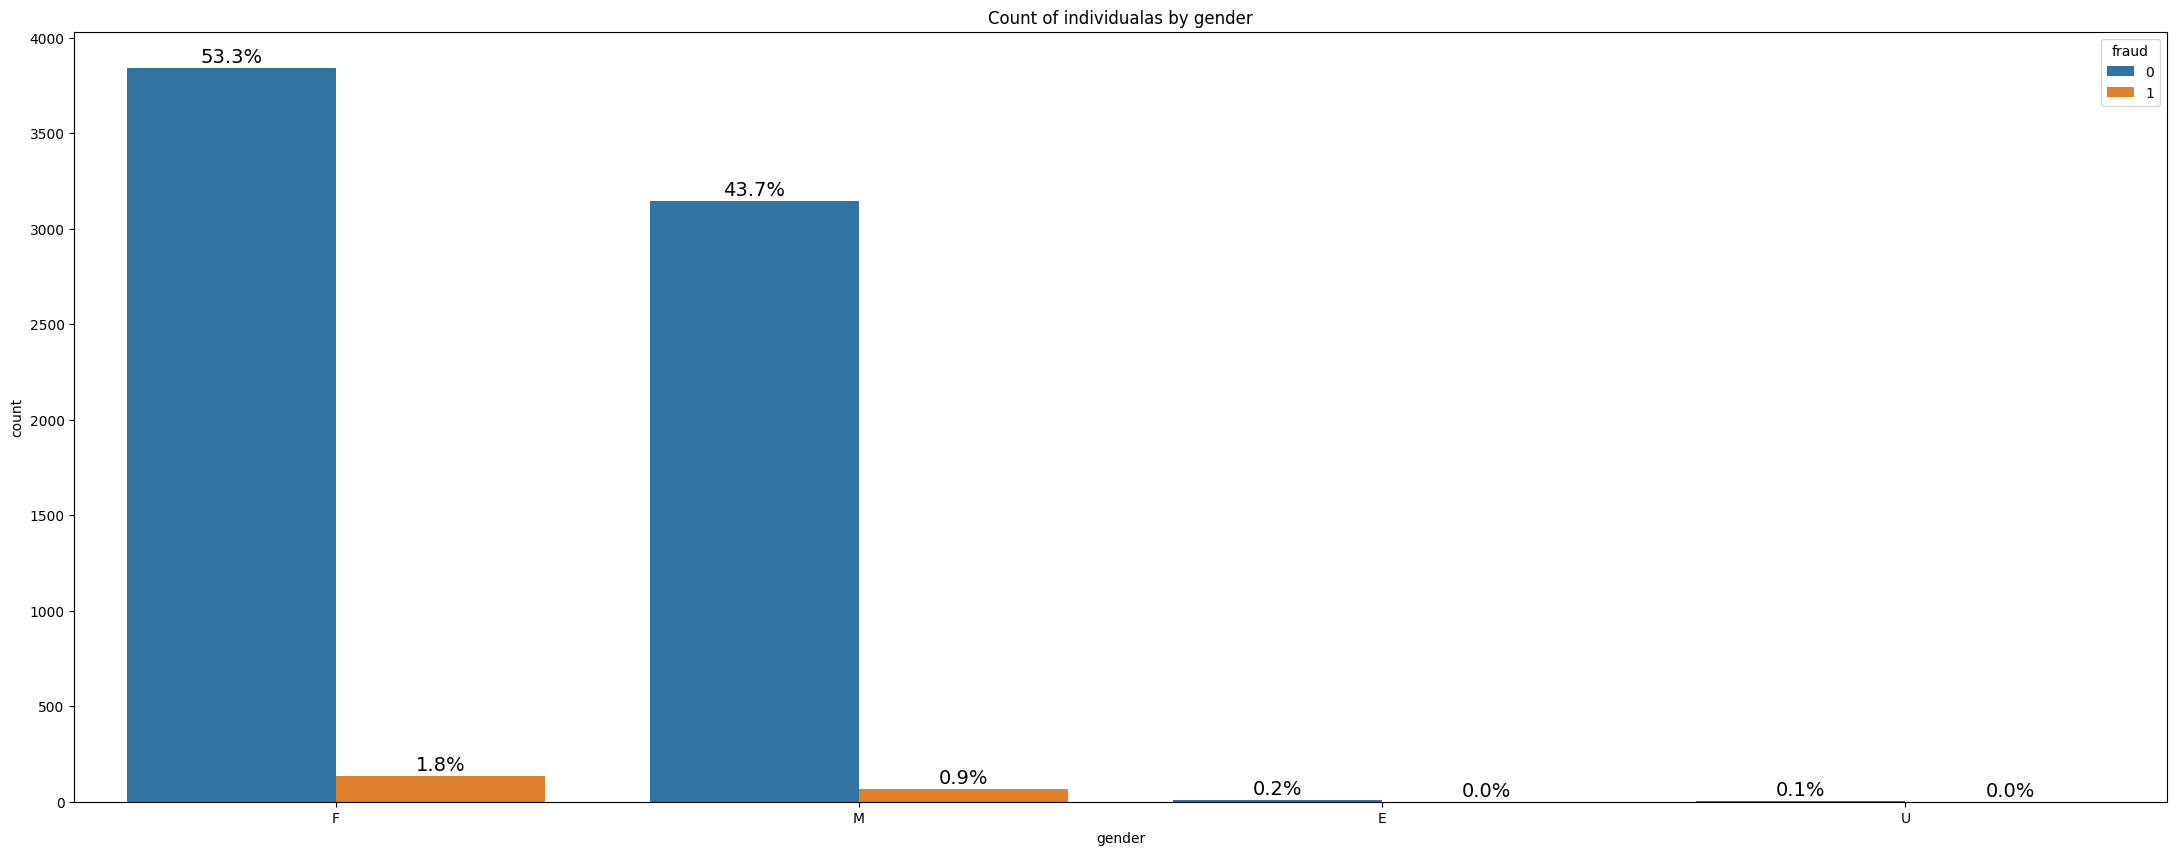

In [ ]:
total = len(df)
fig, axes = plt.subplots(1,1,figsize=(27,10))
sns.countplot(x='gender', hue='fraud',data=df)
axes.set(title="Count of individualas by gender",xlabel="gender")
for p in axes.patches:
    percentage=f'{100*p.get_height()/total:.1f}%\n'
    x=p.get_x()+p.get_width()/2
    y=p.get_height()
    axes.annotate(percentage,(x,y),ha='center',va='center',fontsize=14)


Now, by age in the company:

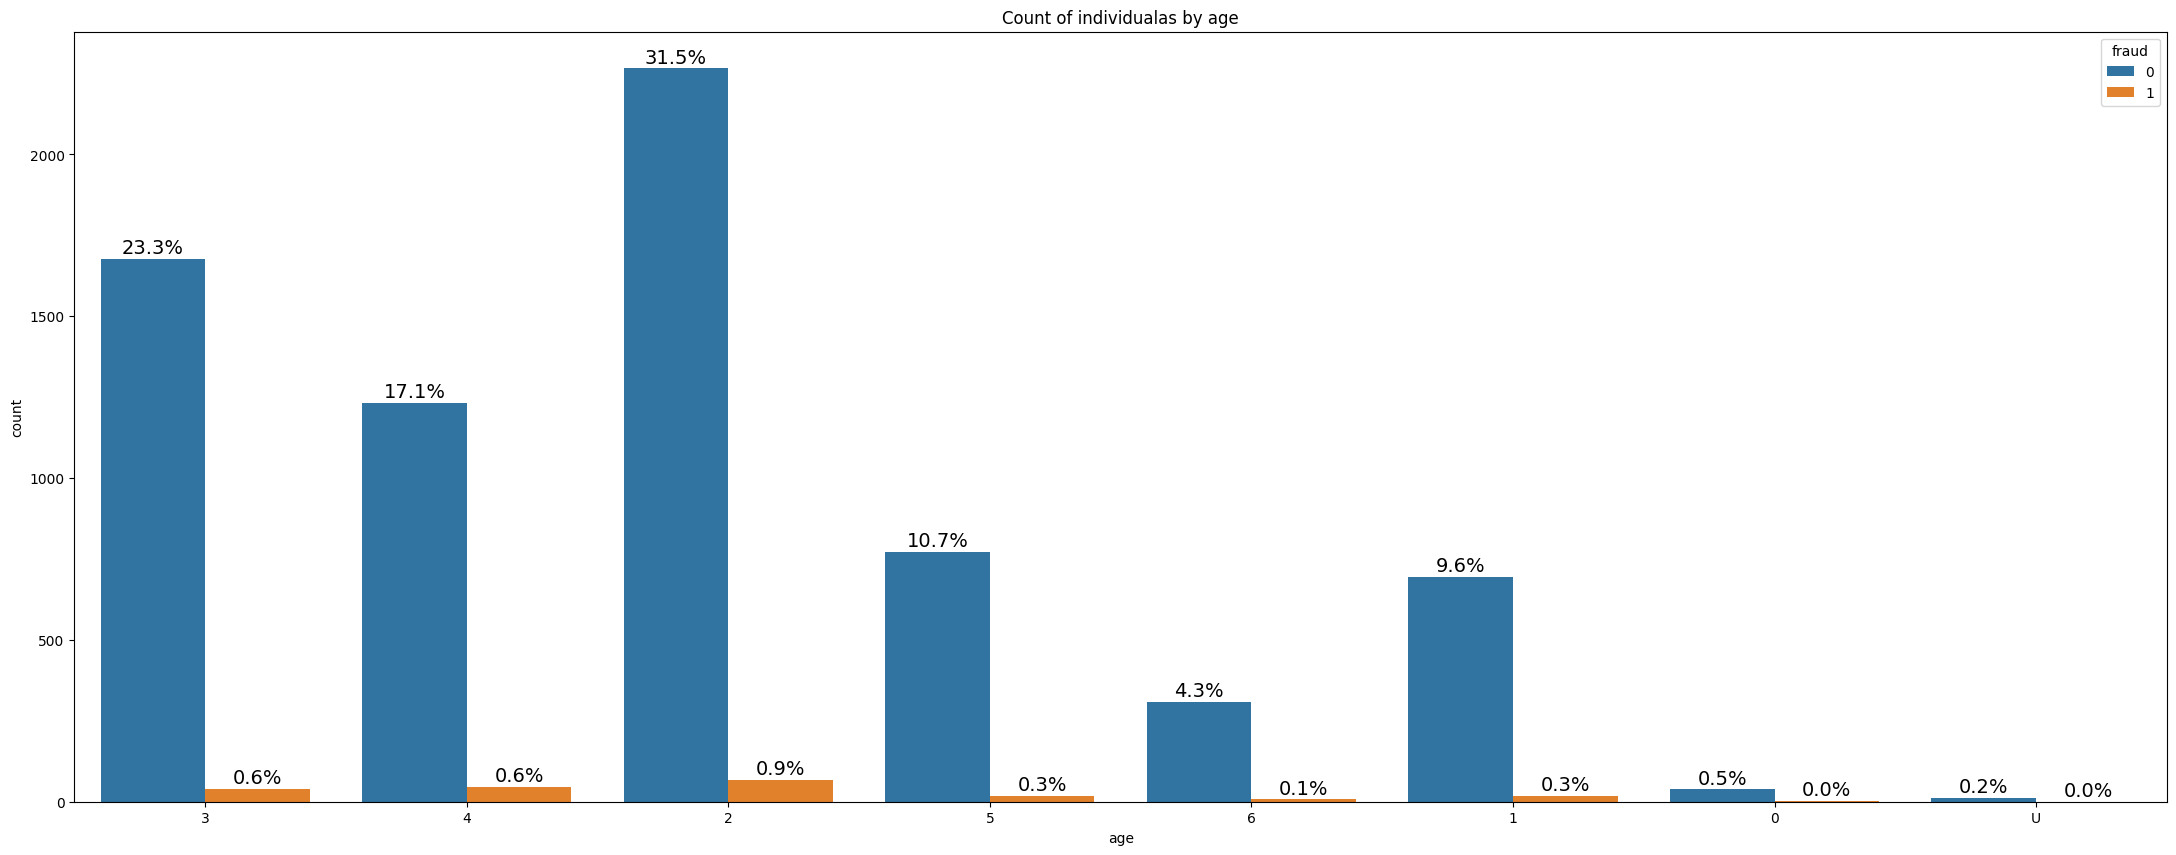

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
total = len(df)
fig, axes = plt.subplots(1,1,figsize=(27,10))
sns.countplot(x='age', hue='fraud',data=df)
axes.set(title="Count of individualas by age", xlabel="age")
for p in axes.patches:
    percentage=f'{100*p.get_height()/total:.1f}%\n'
    x=p.get_x()+p.get_width()/2
    y=p.get_height()
    axes.annotate(percentage,(x,y),ha='center',va='center',fontsize=14)

And finally by inspecting the amount:

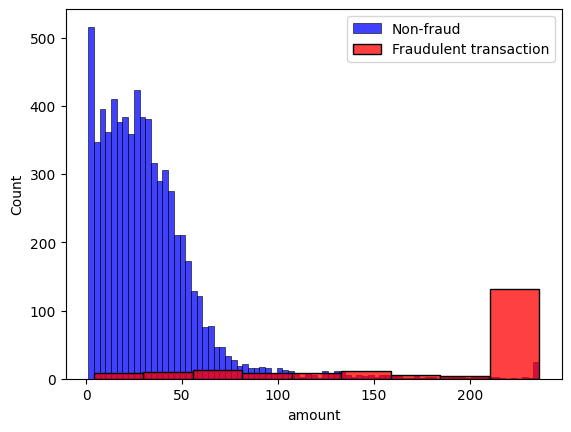

In [ ]:
sns.histplot(df.loc[df['fraud']==0]['amount'], color='blue', label='Non-fraud',common_norm=False)
sns.histplot(df.loc[df['fraud']==1]['amount'], color='red', label='Fraudulent transaction',common_norm=False)
plt.legend()
plt.show()

We observe that the transactions with higher than $200 tend to be more fraudulent. Moreover, the fraudulent transactions tend to be on the larger side relative to normal obervations. This is good news, as it helps us later in detecting fraud from non-fraud.

## Unsupervised ML model:
### K-Means clustering

For ML algorithms using distance based metrics, it is crucial to always scale your data, as features using different scales will distort your results. K-means uses the Euclidian distance to assess distance to cluster centroids.  

We use the class MiniBatchKMeans from sklearn.cluster and tuned the hyperparameters n_clusters,
max_iter, and batch_sizeby using optuna, where we minimize the inertia to obtain thus the best hyperparameters.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import optuna

X = df.loc[:,~df.columns.isin(['Unnamed: 0', 'fraud'])]
y = df["fraud"]
categorical_features = ["age","gender","category"]
numerical_features = ["amount"]

# Pipeline for preprocessing the numerical data
numerical_transformer =  Pipeline(steps=[('imp_num',
                                          SimpleImputer(strategy='median')),
                                         ('sc',MinMaxScaler())])

# Pipeline for preprocessing the categorical data
categorical_transformer=Pipeline(steps=[('imp_cat',
                                         SimpleImputer(strategy='most_frequent')),
                                        ('onehot',
                                         OneHotEncoder(handle_unknown = 'ignore'))])

# Preprocessor
preprocessor = ColumnTransformer(transformers=[('num',numerical_transformer,
                                                numerical_features),
                                               ('cat', categorical_transformer,
                                                categorical_features)])

# The model
kmeans_pipeline = Pipeline(steps=[("preprocess",preprocessor),("kmeans",MiniBatchKMeans(random_state=42))])

def objective(trial):
    n_clusters = trial.suggest_int("n_clusters", 2, 10)
    max_iter = trial.suggest_int("max_iter", 100, 500)
    batch_size = trial.suggest_int("batch_size", 100, 1000)

    kmeans_pipeline.set_params(kmeans__n_clusters=n_clusters,
                               kmeans__max_iter=max_iter,
                               kmeans__batch_size=batch_size)

    kmeans_pipeline.fit(X)

    labels = kmeans_pipeline.named_steps['kmeans'].labels_

    inertia = kmeans_pipeline.named_steps['kmeans'].inertia_

    return inertia

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2023-08-01 23:37:54,286] A new study created in memory with name: no-name-14348202-477b-48a3-a4d6-927fc4d04034
C:\Users\cmuro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[I 2023-08-01 23:37:54,520] Trial 0 finished with value: 5661.400245142673 and parameters: {'n_clusters': 5, 'max_iter': 237, 'batch_size': 142}. Best is trial 0 with value: 5661.400245142673.
C:\Users\cmuro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[I 2023-08-01 23:37:54,857] Trial 1 finished with value: 3232.742212406472 and parameters: {'n_clusters': 10, 'max_iter': 378, 'batch_size': 824}. Best is trial 1 with value: 3232.742212406472.
C:\Users\cmuro\anaconda3\lib\

Therefore, the best hyperparameters found are:

In [ ]:
study.best_params

{'n_clusters': 10, 'max_iter': 496, 'batch_size': 661}

Now going to use the K-means algorithm to predict fraud, and compare those predictions to the actual labels that we saved, to sense check our results.

The fraudulent transactions are typically flagged as the observations that are furthest aways from the cluster centroid. We select the points that are in the top 5th percentile in distance from the cluster centroids.  

In [ ]:
preprocessor = kmeans_pipeline.named_steps['preprocess']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0, stratify=y)

kmeans_pipeline = Pipeline(steps=[("preprocess",preprocessor),
                                  ("kmeans",MiniBatchKMeans(**study.best_params,random_state=42))])

X_test_numeric= (kmeans_pipeline.named_steps['preprocess'].transform(X_test)).astype(float)

kmeans_model = kmeans_pipeline.fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans_model.predict(X_test)
X_test_clusters_centers = kmeans_model.named_steps['kmeans'].cluster_centers_

X_test_numeric_dense = X_test_numeric.toarray()

dist = [np.linalg.norm(x-y) for x, y in zip(X_test_numeric_dense, X_test_clusters_centers[X_test_clusters])]

km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

C:\Users\cmuro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, silhouette_score
print(f"Our roc_score of our model is: {roc_auc_score(y_test, km_y_pred)}")

Our roc_score of our model is: 0.8651428571428572


Moreover, the confusion matrix and classification report are:

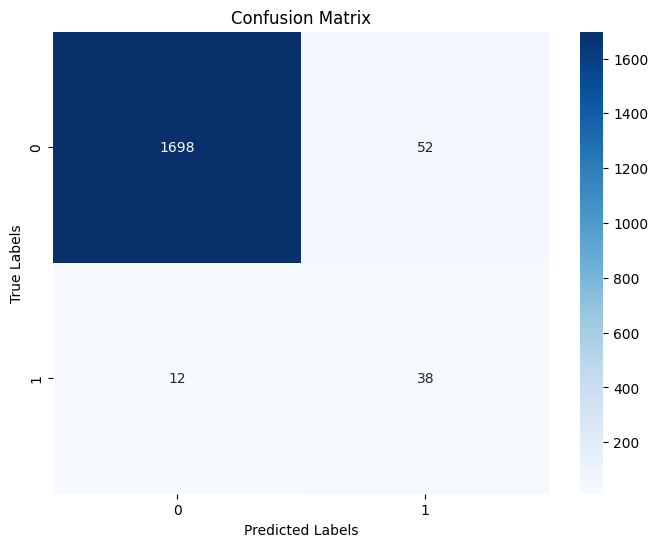

In [ ]:
km_cm = confusion_matrix(y_test, km_y_pred)
labels = sorted(set(y_test))
plt.figure(figsize=(8, 6))
sns.heatmap(km_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, km_y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1750
           1       0.42      0.76      0.54        50

    accuracy                           0.96      1800
   macro avg       0.71      0.87      0.76      1800
weighted avg       0.98      0.96      0.97      1800



## DBSCAN

Now, let us use density based clustering method (DBSCAN) to detect fraud.  

The advantage of DBSCAN is that we do not need to define the number of clusters beforehand. Also, DBSCAN can handle weirdly shaped data (i.e. non-convex) much better than K-means can.  
  
Initialize a DBSCAN model setting the maximum distance between two samples to 0.9 and the minimum observations in the clusters to 10.    
      
This time, we're not going to take the outliers of the clusters and use that for fraud, but take the smallest clusters in the data and label those as fraud.

In [ ]:
from sklearn.cluster import DBSCAN

X_scaled = (kmeans_pipeline.named_steps['preprocess'].transform(X)).toarray()
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(kmeans_pipeline.named_steps['preprocess'].transform(X))

pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters)
print("The Silhouette Coefficient: %0.3f" % silhouette_score(X_scaled, pred_labels))

Estimated number of clusters: 54
The Silhouette Coefficient: 0.860


Since our Silhouette coefficient is close to 1, we got a model with good grouping.

## Conclusions

* For the kmeans, we found throuhg optuna minimizing the inertia, that best model should has the parameters 'n_clusters': 10, 'max_iter': 496, 'batch_size': 661. The area under roc curve has a value of 0.86.  

* Using a dbscan model we got a Silhouette Coefficient of 0.860.